# **Analyse**

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
from imblearn.over_sampling import SMOTE

**Data loading**

Data frame pour visualisation

In [198]:
df = pd.read_csv('./data/final_data.zip')

C:\Users\eva2p\AppData\Local\Temp\ipykernel_15128\459618280.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/final_data.zip')


In [99]:
df.sample(5)

,ID_ANSSI,Titre,Type,Date,CVE,CVSS,Base Severity,CWE,EPSS,Lien,Description,Éditeur,Produit,Versions affectées,Remote exploitable,Longueur description
76040,CERTFR-2023-AVI-0935,Multiples vulnérabilités dans les produits Sie...,Avis,2023-11-14T00:00:00.000000,CVE-2023-44319,4.9,Moyenne,CWE-328,0.00056,https://www.cert.ssi.gouv.fr/openapi.json,A vulnerability has been identified in RUGGEDC...,Siemens,SCALANCE WAM763-1 (ME),0,False,3026.0
162504,CERTFR-2025-AVI-0024,Multiples vulnérabilités dans le noyau Linux d...,Avis,2025-01-10T12:49:22.929315,CVE-2024-42229,NaN,NaN,Non disponible,0.00034,https://www.cert.ssi.gouv.fr/openapi.json,"In the Linux kernel, the following vulnerabili...",Linux,Linux,"4.19.323, 5.4.285, 5.10.222, 5.15.163, 6.1.98,...",False,358.0
90811,CERTFR-2024-AVI-0779,Multiples vulnérabilités dans le noyau Linux d...,Avis,2024-09-13T00:00:00.000000,CVE-2022-48906,NaN,NaN,Non disponible,0.00028,https://www.cert.ssi.gouv.fr/openapi.json,"In the Linux kernel, the following vulnerabili...",Linux,Linux,"5.13, 0, 5.15.27, 5.16.13, 5.17",False,1505.0
28091,CERTFR-2025-AVI-0509,Multiples vulnérabilités dans le noyau Linux d...,Avis,2025-06-13T00:00:00.000000,CVE-2025-21881,NaN,NaN,Non disponible,0.00039,https://www.cert.ssi.gouv.fr/openapi.json,"In the Linux kernel, the following vulnerabili...",Linux,Linux,"3.5, 0, 6.1.130, 6.6.81, 6.12.18, 6.13.6, 6.14",True,3452.0
25932,CERTFR-2023-AVI-0577,Multiples vulnérabilités dans le noyau Linux d...,Avis,2023-07-21T00:00:00.000000,CVE-2023-1073,6.6,Moyenne,CWE-119,0.00018,https://www.cert.ssi.gouv.fr/openapi.json,A memory corruption flaw was found in the Linu...,NaN,kernel,unknown,False,236.0


In [100]:
df.shape

(225314, 16)

In [200]:
df_avant_clean = df.copy()

# Data cleaning

Conversion des types

In [101]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M:%S.%f', errors='coerce')
df["CVSS"] = pd.to_numeric(df["CVSS"], errors="coerce")
df["EPSS"] = pd.to_numeric(df["EPSS"], errors="coerce")

CVSS cleaning

In [102]:
# si moins de 10% sont vides -> supprimer, sinon -> remplir
cvss_nan_pct = df["CVSS"].isna().mean()
if cvss_nan_pct < 0.1:
    df = df.dropna(subset=["CVSS"])
else: 
    df["CVSS"] = df["CVSS"].fillna(df["CVSS"].median())
    print("Choix : remplacer par la valeur médiane") #median pour éviter les outliers

Choix : remplacer par la valeur médiane


EPSS cleaning

In [103]:
epss_nan_pct = df["EPSS"].isna().mean()
if epss_nan_pct < 0.1:
    df = df.dropna(subset=["EPSS"])
else:
    df["EPSS"] = df["EPSS"].fillna(df["EPSS"].median())
    print("Choix : remplacer par la valeur médiane")

In [104]:
df.shape

(224411, 16)

In [105]:
df = df[df["CWE"] != "Non disponible"]

In [106]:
df.shape

(118702, 16)

Base severity

In [107]:
def gravite_from_cvss(cvss):
    if pd.isna(cvss):
        return "Non spécifié"
    if cvss >= 9.0:
        return "Critique"
    elif cvss >= 7.0:
        return "Élevée"
    elif cvss >= 4.0:
        return "Moyenne"
    else:
        return "Faible"

df["Base Severity"] = df["CVSS"].apply(gravite_from_cvss)

Supprimer lignes avec valeurs manquantes pour l'éditeur ou le produit

In [108]:
df = df[df["Éditeur"].notna() & (df["Éditeur"] != "Non précisé")]
df = df[df["Produit"].notna()]

In [109]:
df.shape

(110770, 16)

In [196]:
df.sample(8)

,ID_ANSSI,Titre,Type,Date,CVE,CVSS,Base Severity,CWE,EPSS,Lien,...,Éditeur,Produit,Versions affectées,Remote exploitable,Longueur description,Gravité,Gravité_CVSS,Probabilité_EPSS,Mois,Année
173552,CERTFR-2024-AVI-1070,Multiples vulnérabilités dans les produits Mic...,Avis,2024-12-11 12:54:53.609421,CVE-2024-49065,5.5,Moyenne,CWE-125,0.00055,https://www.cert.ssi.gouv.fr/openapi.json,...,Microsoft,Microsoft Word 2016,16.0.1,False,52.0,Moyenne,Moyenne,Faible,2024-12,2024
186015,CERTFR-2024-AVI-0631,Multiples vulnérabilités dans le noyau Linux d...,Avis,2024-07-26 11:51:01.297398,CVE-2024-35899,6.1,Moyenne,CWE-362,0.00034,https://www.cert.ssi.gouv.fr/openapi.json,...,Linux,Linux,"0935d558840099b3679c67bb7468dc78fcbad940, 0935...",False,3998.0,Élevée,Élevée,Faible,2024-07,2024
216624,CERTFR-2024-AVI-0958,Multiples vulnérabilités dans les produits IBM,Avis,2024-11-08 13:05:28.013204,CVE-2023-50782,7.5,Élevée,CWE-208,0.00521,https://www.cert.ssi.gouv.fr/openapi.json,...,Red Hat,Red Hat Enterprise Linux 9,NaN,True,225.0,Élevée,Élevée,Faible,2024-11,2024
136243,CERTFR-2024-AVI-0506,Multiples vulnérabilités dans Juniper Secure A...,Avis,2024-06-19 11:30:45.857102,CVE-2023-6536,6.5,Moyenne,CWE-476,0.00146,https://www.cert.ssi.gouv.fr/openapi.json,...,Red Hat,RHOL-5.8-RHEL-9,v1.1.0-227,False,291.0,Élevée,Élevée,Faible,2024-06,2024
87289,CERTFR-2024-AVI-1040,Vulnérabilité dans Moxa VPort 07-3 Series,Avis,2024-12-04 00:00:00.000000,CVE-2024-9404,5.3,Moyenne,CWE-1287,0.00159,https://www.cert.ssi.gouv.fr/openapi.json,...,Moxa,VPort 07-3 Series,1.0,True,336.0,Moyenne,Moyenne,Faible,2024-12,2024
72853,CERTFR-2024-AVI-0694,Multiples vulnérabilités dans le noyau Linux d...,Avis,2024-08-16 00:00:00.000000,CVE-2024-38605,8.8,Élevée,CWE-476,0.00560,https://www.cert.ssi.gouv.fr/openapi.json,...,Linux,Linux,"81033c6b584b44514cbb16fffc26ca29a0fa6270, 8103...",False,1395.0,Critique,Critique,Faible,2024-08,2024
99593,CERTFR-2025-AVI-0057,Multiples vulnérabilités dans Oracle Virtualiz...,Avis,2025-01-22 00:00:00.000000,CVE-2025-21533,5.5,Moyenne,CWE-863,0.00029,https://www.cert.ssi.gouv.fr/openapi.json,...,Oracle Corporation,Oracle VM VirtualBox,"*, *",False,612.0,Moyenne,Moyenne,Faible,2025-01,2025
45361,CERTFR-2024-AVI-1072,Multiples vulnérabilités dans les produits Apple,Avis,2024-12-12 00:00:00.000000,CVE-2024-54513,5.7,Moyenne,CWE-281,0.00019,https://www.cert.ssi.gouv.fr/openapi.json,...,Apple,tvOS,unspecified,False,221.0,Moyenne,Moyenne,Faible,2024-12,2024


Data frame pour modèles machine learning

In [110]:
df_IA = df.copy()

# **Visualisation**

**Severity level categorization function**

In [111]:
def cvss_to_severity(score):
    try:
        score = float(score)
        if score <= 3:
            return 'Faible'
        elif score <= 6:
            return 'Moyenne'
        elif score <= 8:
            return 'Élevée'
        else:
            return 'Critique'
    except:
        return 'Inconnu'

## 1. Histogram of severity levels (based on CVSS)

Avant cleaning

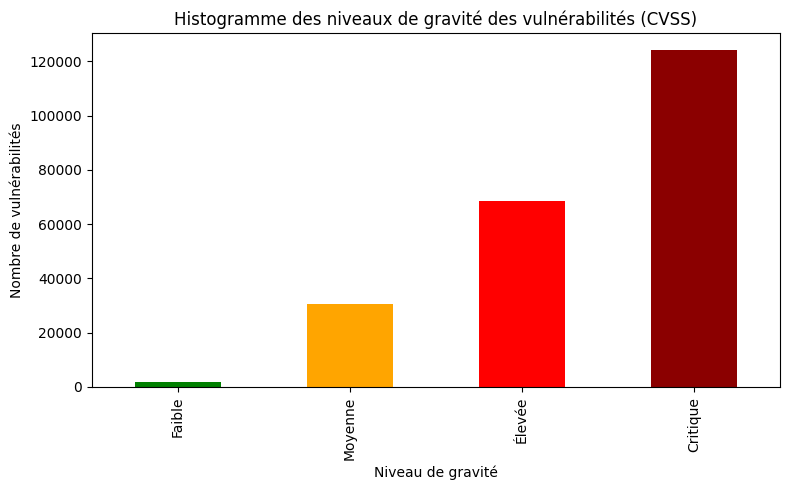

In [201]:
df_avant_clean['Gravité'] = df_avant_clean['CVSS'].apply(cvss_to_severity)
grav_counts = df_avant_clean['Gravité'].value_counts().reindex(['Faible', 'Moyenne', 'Élevée', 'Critique'], fill_value=0)

# Plot
plt.figure(figsize=(8,5))
grav_counts.plot(kind='bar', color=['green', 'orange', 'red', 'darkred', 'gray'])
plt.title('Histogramme des niveaux de gravité des vulnérabilités (CVSS)')
plt.xlabel('Niveau de gravité')
plt.ylabel('Nombre de vulnérabilités')
plt.tight_layout()
plt.show()

_Dans l'histogramme avant nettoyage, on observe une forte dominance de la classe "Critique", qui dépasse nettement les 120 000 occurrences. La classe "Élevée" suit, avec environ 70 000 cas, tandis que les classes "Moyenne" et surtout "Faible" sont très sous-représentées (moins de 5 000 cas pour "Faible")._

Après clean

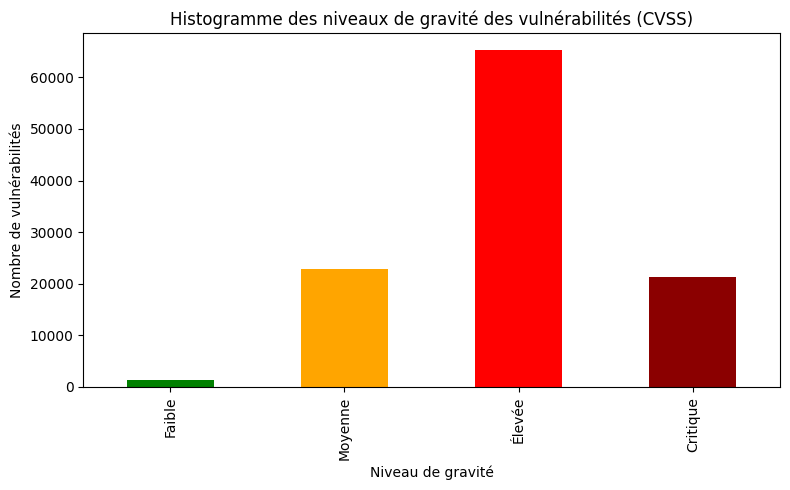

In [112]:
df['Gravité'] = df['CVSS'].apply(cvss_to_severity)
grav_counts = df['Gravité'].value_counts().reindex(['Faible', 'Moyenne', 'Élevée', 'Critique'], fill_value=0)

# Plot
plt.figure(figsize=(8,5))
grav_counts.plot(kind='bar', color=['green', 'orange', 'red', 'darkred', 'gray'])
plt.title('Histogramme des niveaux de gravité des vulnérabilités (CVSS)')
plt.xlabel('Niveau de gravité')
plt.ylabel('Nombre de vulnérabilités')
plt.tight_layout()
plt.show()

_Dans le graphique après nettoyage, la classe "Critique" chute à environ 21 000 vulnérabilités, tandis que la classe "Élevée" devient majoritaire avec environ 65 000 cas. La classe "Moyenne" reste relativement stable, et "Faible" toujours marginale._

_Ce changement significatif s’explique par notre stratégie de remplissage des valeurs manquantes de CVSS par la médiane. Si cette médiane correspond à un score de gravité élevé mais non critique (entre 6.0 et 8.9), alors les vulnérabilités précédemment non classées ont été affectées à la classe "Élevée", ce qui réduit artificiellement la part des "Critique" et augmente mécaniquement celle des "Élevée"._

## 2. Circular vulnerability diagram (CWE)

Top 10 CWE les plus fréquents, les autres groupés par "Others"

In [113]:
top_cwe = df['CWE'].value_counts()
top_18 = top_cwe.head(18)
autres = top_cwe[18:].sum()
top_18['Autres'] = autres

Plot

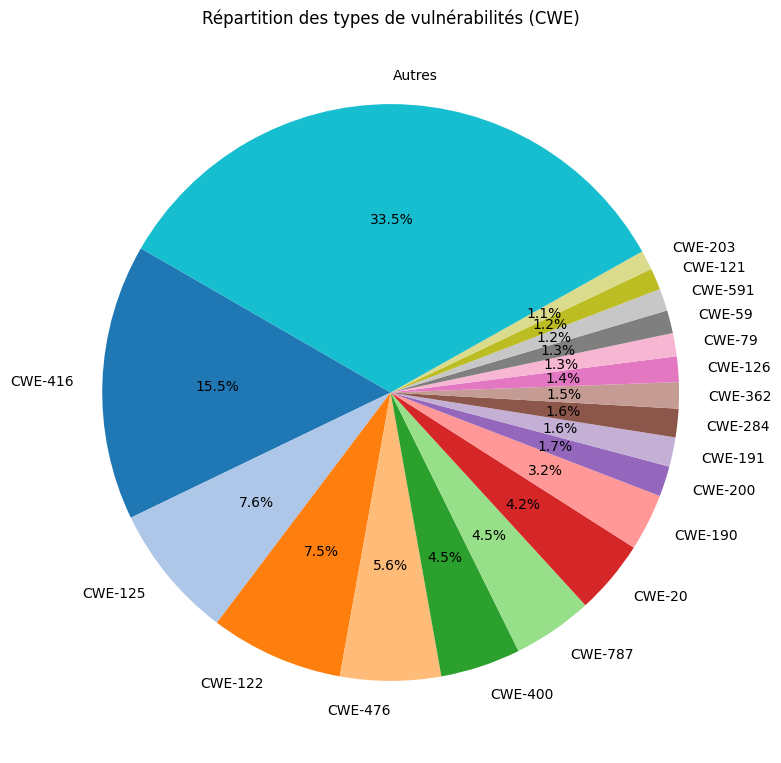

In [114]:
plt.figure(figsize=(8,8))
colors = plt.cm.tab20.colors[:len(top_18)]
top_18.plot(kind='pie', autopct='%1.1f%%', startangle=150, colors=colors)
plt.title('Répartition des types de vulnérabilités (CWE)')
plt.ylabel('')
plt.tight_layout()
plt.show()

## 3. EPSS Score Density Curve

In [115]:
epss = df['EPSS']

Plot

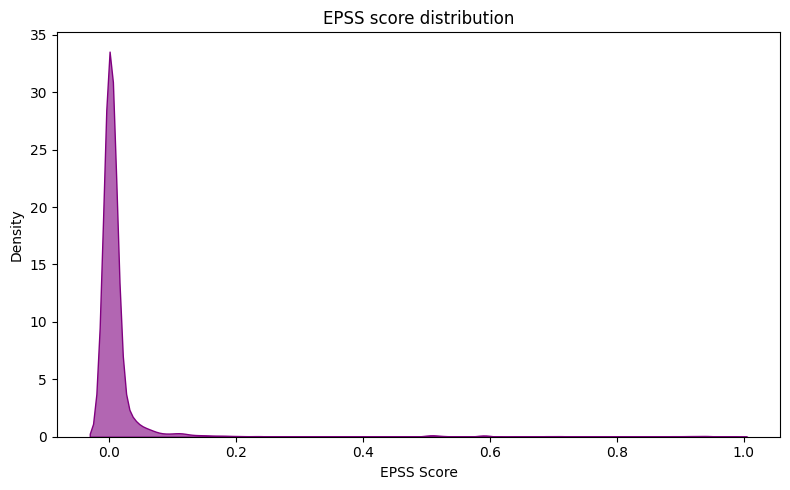

In [116]:
plt.figure(figsize=(8, 5))
sns.kdeplot(epss, fill=True, color="purple", alpha=0.6)
plt.title('EPSS score distribution')
plt.xlabel('EPSS Score')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

Zoom sur les petits EPSS Score

In [117]:
epss_filtered = epss[(epss >= 0) & (epss <= 0.10)]

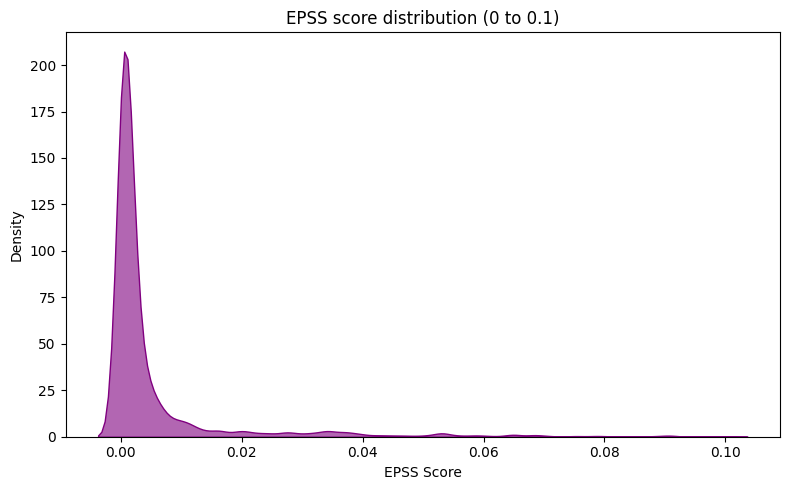

In [118]:
plt.figure(figsize=(8, 5))
sns.kdeplot(epss_filtered, fill=True, color="purple", alpha=0.6)
plt.title('EPSS score distribution (0 to 0.1)')
plt.xlabel('EPSS Score')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

## 4. Top Affected editors

Top 10 editeurs les plus fréquents

In [119]:
top_editors = df['Éditeur'].value_counts().head(10)

Plot

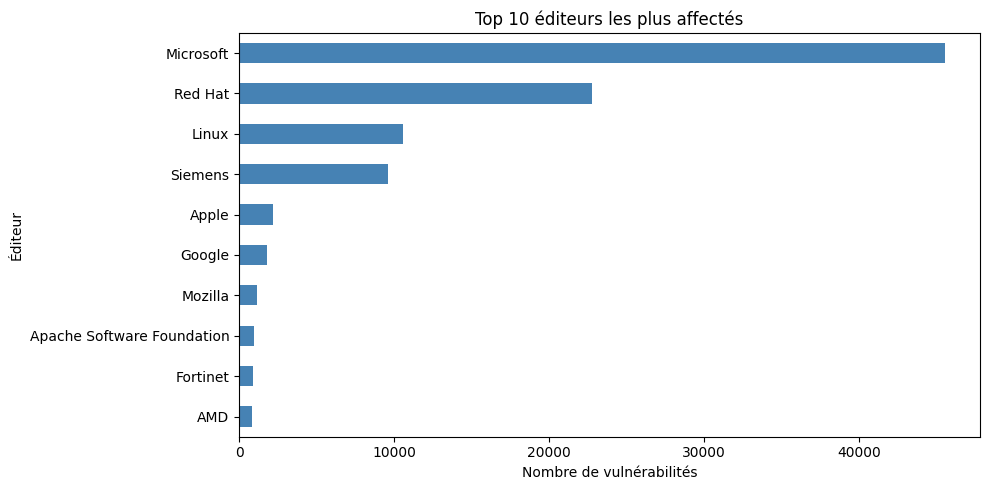

In [120]:
plt.figure(figsize=(10, 5))
top_editors.plot(kind='barh', color='steelblue')
plt.title('Top 10 éditeurs les plus affectés')
plt.xlabel('Nombre de vulnérabilités')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 5. Top affected products

Top 10 produits les plus fréquents

In [121]:
top_products = df['Produit'].value_counts().head(10)

Plot

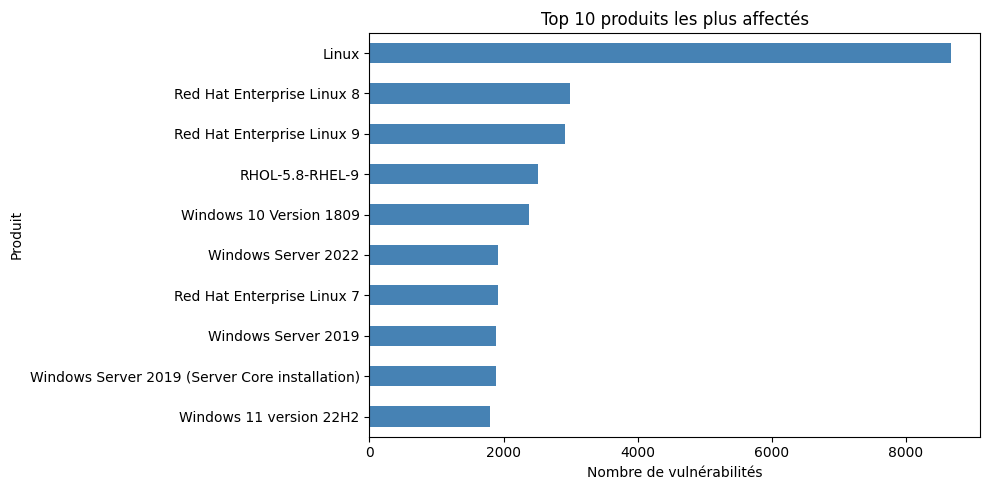

In [122]:
plt.figure(figsize=(10, 5))
top_products.plot(kind='barh', color='steelblue')
plt.title('Top 10 produits les plus affectés')
plt.xlabel('Nombre de vulnérabilités')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Heatmap : Correlation between CVSS and EPSS

Créer un dataframe correlation

In [123]:
correlation_df = df[["CVSS", "EPSS"]]

In [124]:
df["Gravité_CVSS"] = df["CVSS"].apply(cvss_to_severity)

Categoriser EPSS en 4 niveaux

In [125]:
def epss_to_level(epss):
    if epss <= 0.25:
        return "Faible"
    elif epss <= 0.5:
        return "Moyenne"
    elif epss <= 0.75:
        return "Élevée"
    else:
        return "Critique"

In [126]:
df["Probabilité_EPSS"] = df["EPSS"].apply(epss_to_level)

Création de la heatmap

In [127]:
heatmap_data = pd.crosstab(df["Gravité_CVSS"], df["Probabilité_EPSS"])
heatmap_data = heatmap_data.reindex(index=["Critique", "Élevée", "Moyenne", "Faible"],
                                     columns=["Faible", "Moyenne", "Élevée", "Critique"])

Plot

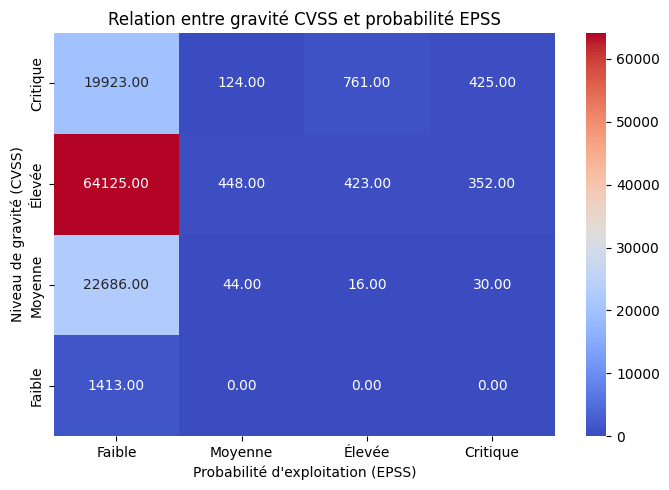

In [128]:
plt.figure(figsize=(7, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Relation entre gravité CVSS et probabilité EPSS")
plt.xlabel("Probabilité d'exploitation (EPSS)")
plt.ylabel("Niveau de gravité (CVSS)")
plt.tight_layout()
plt.show()

## 7. Scatter plot : CVSS vs EPSS

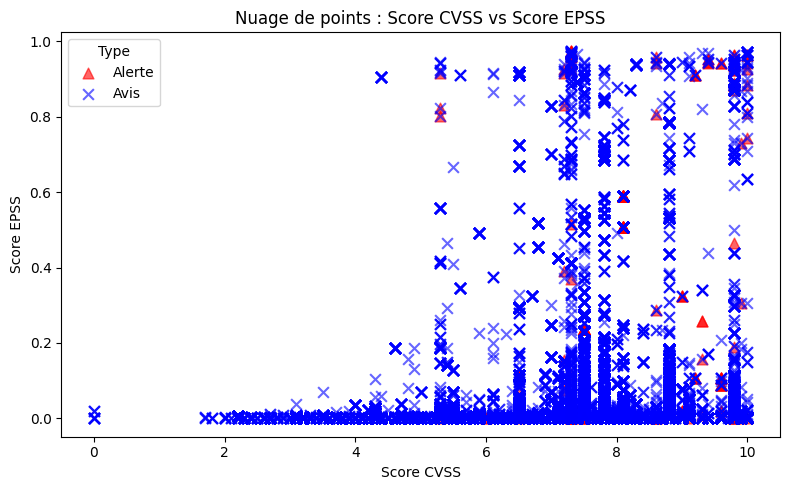

In [129]:
plt.figure(figsize=(8, 5))

# Couleurs et marqueurs pour chaque type
color_map = {'Alerte': 'red', 'Avis': 'blue'}
marker_map = {'Alerte': '^', 'Avis': 'x'}

for t in ['Alerte', 'Avis']:
    subset = df[df['Type'] == t]
    plt.scatter(subset['CVSS'], subset['EPSS'],
                color=color_map[t],
                marker=marker_map[t],
                alpha=0.6,
                s=60,
                label=t)

plt.title("Nuage de points : Score CVSS vs Score EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.legend(title="Type")
plt.tight_layout()
plt.show()


## 8. Courbe cumulative : Vulnérabilités dans le temps

In [130]:
df_sorted = df.sort_values("Date")

Regroupement par date et calcul de la somme cumulée

In [131]:
cumulative_df = df_sorted.groupby("Date").size().cumsum()

Plot

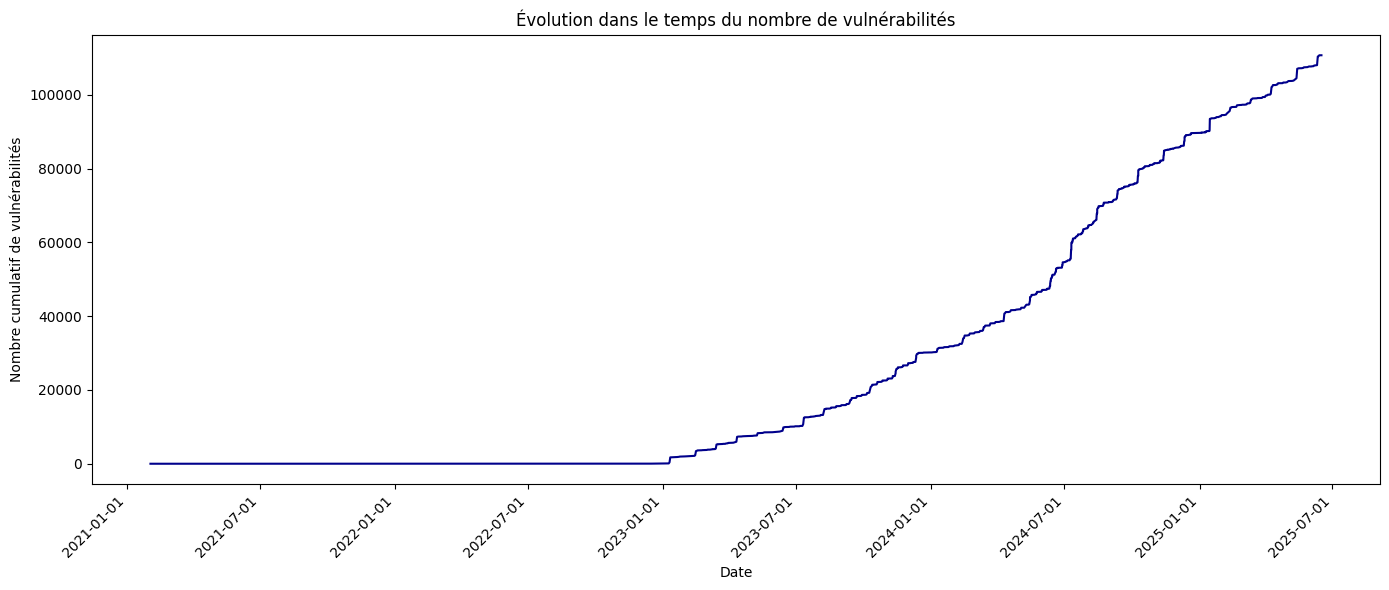

In [132]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(cumulative_df.index, cumulative_df.values, color="darkblue")

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

plt.title("Évolution dans le temps du nombre de vulnérabilités")
plt.xlabel("Date")
plt.ylabel("Nombre cumulatif de vulnérabilités")
plt.tight_layout()
plt.show()

## 9. Boxplot : scores CVSS par top éditeurs

Filtre

In [133]:
top_editors = df['Éditeur'].value_counts().head(10).index
boxplot_df = df[df['Éditeur'].isin(top_editors)]

Plot

C:\Users\eva2p\AppData\Local\Temp\ipykernel_15128\3526360994.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=boxplot_df, x='Éditeur', y='CVSS', palette='Set2')


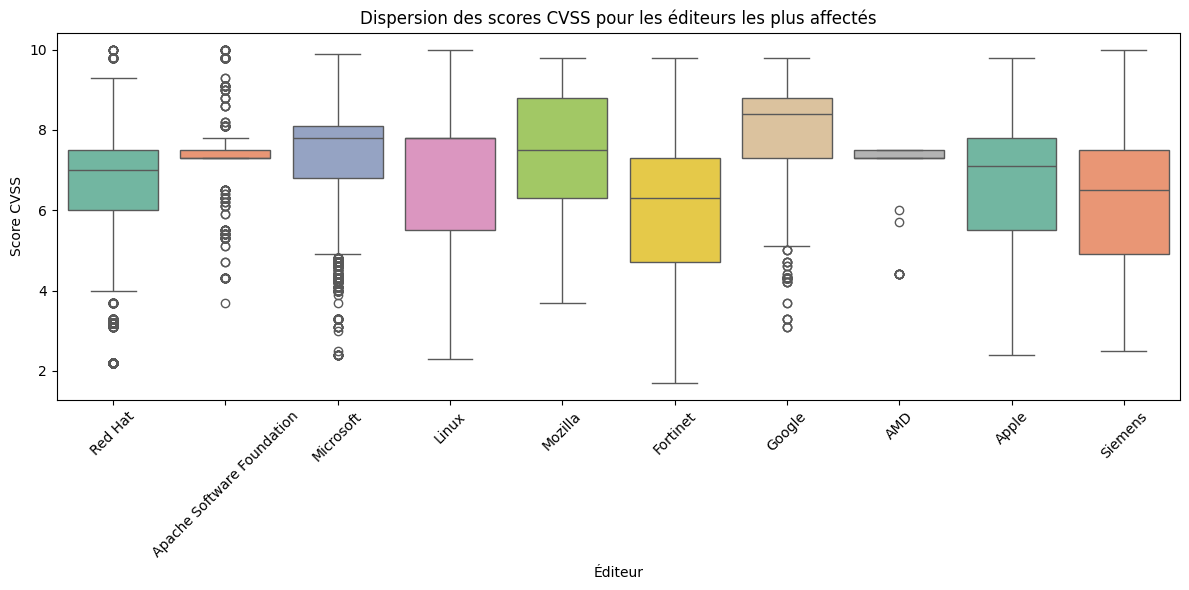

In [134]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=boxplot_df, x='Éditeur', y='CVSS', palette='Set2')
plt.title('Dispersion des scores CVSS pour les éditeurs les plus affectés')
plt.xlabel('Éditeur')
plt.ylabel('Score CVSS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 10. Évolution temporelle des vulnérabilités CWE-416 (« Use After Free » : utilisation après libération de la mémoire)

In [135]:
cwe_416_df = df[df["CWE"] == "CWE-416"]

Grouper par mois

In [136]:
cwe_416_monthly = cwe_416_df.groupby(df["Date"].dt.to_period("M")).size()
cwe_416_monthly.index = cwe_416_monthly.index.to_timestamp()

Plot

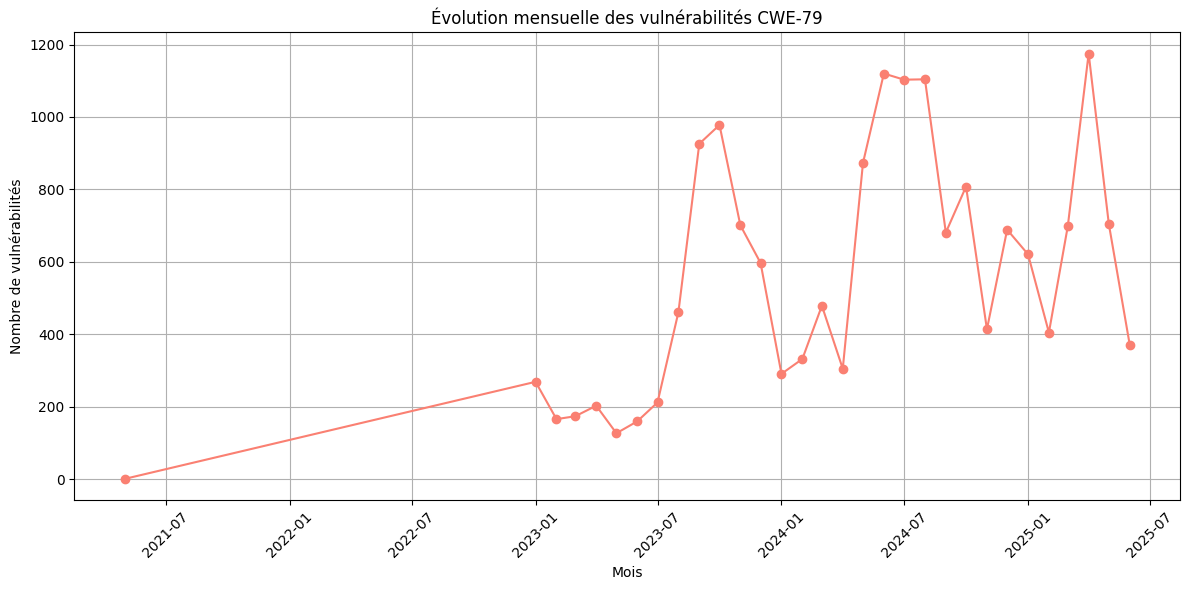

In [137]:
plt.figure(figsize=(12, 6))
plt.plot(cwe_416_monthly.index, cwe_416_monthly.values, marker="o", linestyle="-", color="salmon")
plt.title("Évolution mensuelle des vulnérabilités CWE-79")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 11. Histogramme des vulnérabilités par produit pour CWE-125 : Lecture hors limites

Selection du CWE-125

In [138]:
cwe_cible = "CWE-125"
df_cwe = df[df["CWE"] == cwe_cible]

Compter les vulnérabilités par produit

In [139]:
produit_counts = df_cwe["Produit"].value_counts().sort_values(ascending=False).head(15)

Plot

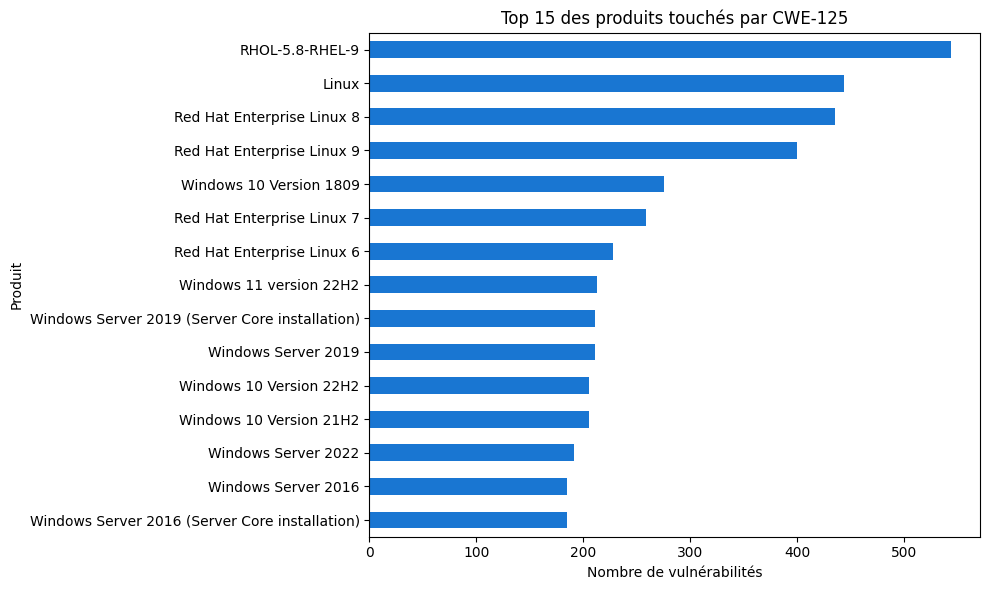

In [140]:
plt.figure(figsize=(10,6))
produit_counts.plot(kind="barh", color="#1976D2")
plt.gca().invert_yaxis()
plt.title(f"Top 15 des produits touchés par {cwe_cible}")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Produit")
plt.tight_layout()
plt.show()

## 12. Heatmap CWE x editeur

Heatmap

In [141]:
heatmap_data = pd.crosstab(df["CWE"], df["Éditeur"])

Selection (sinon trop de valeurs)

In [142]:
top_cwe = heatmap_data.sum(axis=1).sort_values(ascending=False).head(15).index
top_editeurs = heatmap_data.sum(axis=0).sort_values(ascending=False).head(14).index
filtered_data = heatmap_data.loc[top_cwe, top_editeurs]

Plot

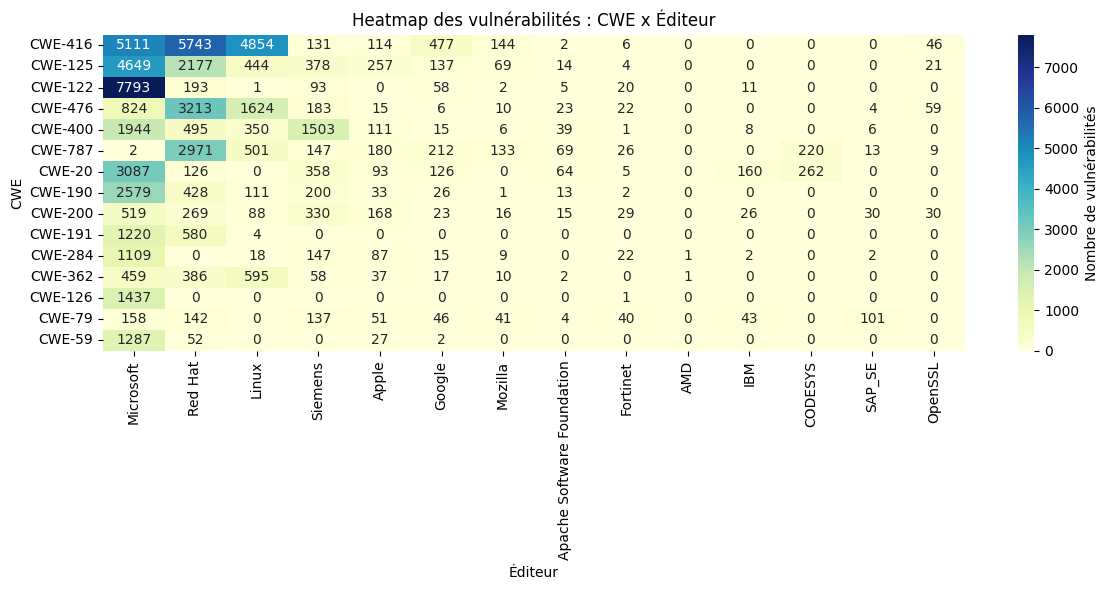

In [143]:
plt.figure(figsize=(12, 6))
sns.heatmap(filtered_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Nombre de vulnérabilités'})
plt.title("Heatmap des vulnérabilités : CWE x Éditeur")
plt.xlabel("Éditeur")
plt.ylabel("CWE")
plt.tight_layout()
plt.show()

## 13. Tendances mensuelles de la vulnérabilité par CWE (courbes superposées)

Extraction du mois et de l'année

In [144]:
df["Mois"] = df["Date"].dt.to_period("M")  # Format AAAA-MM

Garder les 8 CWE les plus fréquents

In [145]:
top_cwes = df[df["CWE"] != "Non disponible"]["CWE"].value_counts().head(5).index
df_top = df[df["CWE"].isin(top_cwes)]

Garder seulement après janvier 2023

In [146]:
df_top = df_top[df_top["Mois"] >= "2023-01"]

Groupement : nombre de vulnérabilités par mois et par CWE

In [147]:
df_grouped = df_top.groupby(["Mois", "CWE"]).size().unstack(fill_value=0)

Plot

<Figure size 1200x600 with 0 Axes>

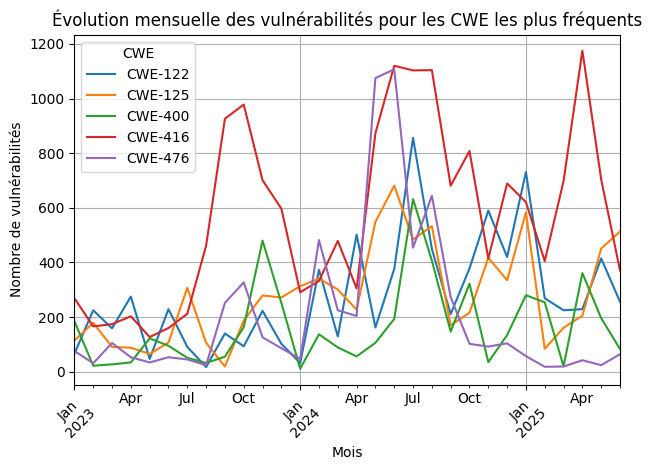

In [148]:
plt.figure(figsize=(12, 6))
df_grouped.plot()
plt.title("Évolution mensuelle des vulnérabilités pour les CWE les plus fréquents")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.legend(title="CWE")
plt.tight_layout()
plt.grid(True)
plt.show()

## 14. Heatmap : vunerabilités temporelles

In [149]:
df["Année"] = df["Date"].dt.year
df["Mois"] = df["Date"].dt.month

In [150]:
pivot = pd.crosstab(df["Année"], df["Mois"]).fillna(0)

Plot

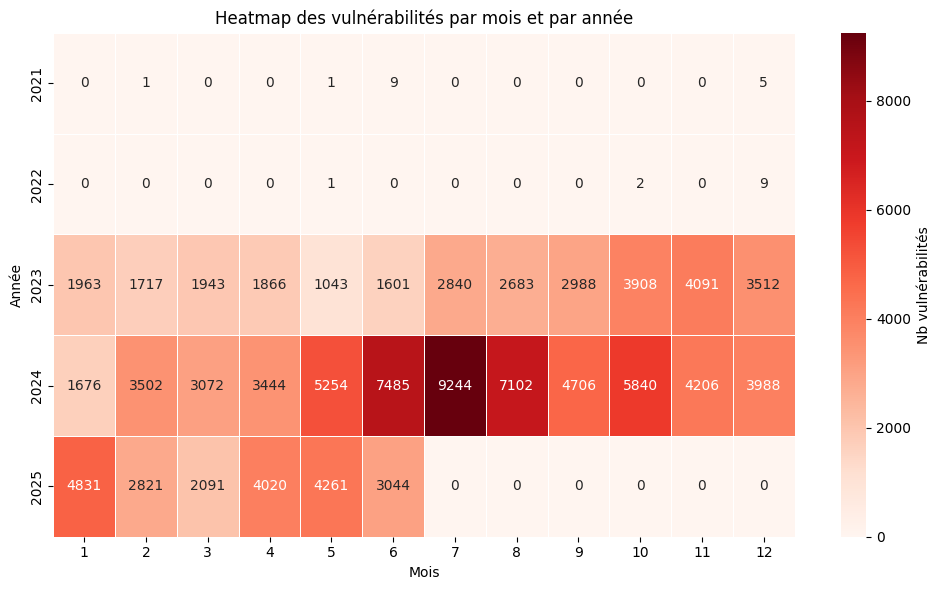

In [151]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="Reds", annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Nb vulnérabilités'})
plt.title("Heatmap des vulnérabilités par mois et par année")
plt.xlabel("Mois")
plt.ylabel("Année")
plt.tight_layout()
plt.show()

## 15. Scatter : produit & version

Définir produits et versions les plus fréquents

In [152]:
top_produits = df["Produit"].value_counts().head(25).index
top_versions = df["Versions affectées"].value_counts().head(15).index

In [153]:
df_top_both = df[
    (df["Produit"].isin(top_produits)) &
    (df["Versions affectées"].isin(top_versions))
]

df_top_both.loc[:, "Versions affectées"] = df_top_both["Versions affectées"].apply(
    lambda v: v if len(v) <= 20 else v[:17] + "..."
)

Plot

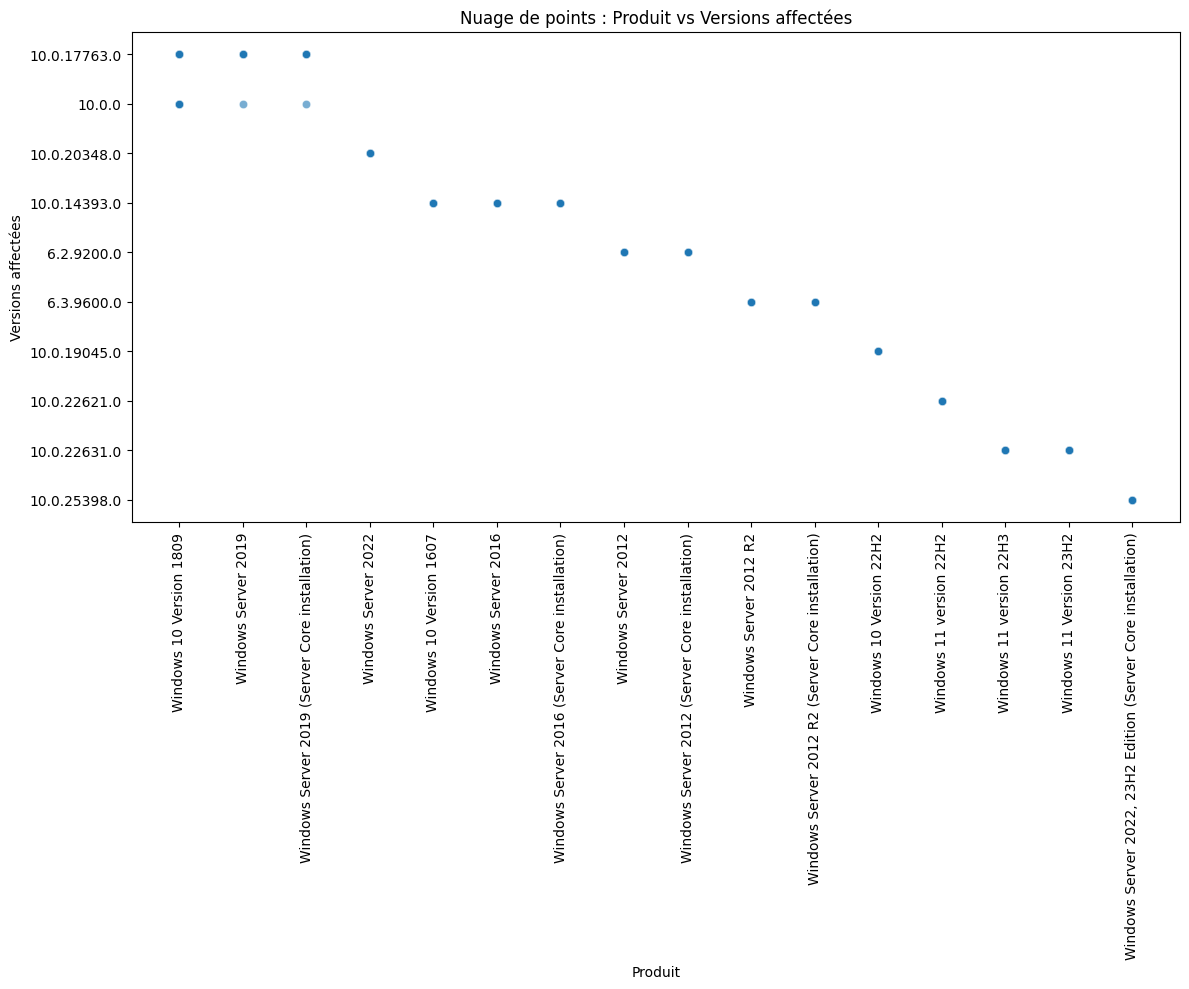

In [154]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_top_both, x="Produit", y="Versions affectées", alpha=0.6)

plt.xticks(rotation=90)
plt.title("Nuage de points : Produit vs Versions affectées")
plt.xlabel("Produit")
plt.ylabel("Versions affectées")
plt.tight_layout()
plt.show()

## 16. Bar chart : top 10 versions les plus impactées par les vulnerabilités

Filtrer

In [155]:
versions = df["Versions affectées"]
versions = versions[versions != "n/a"]

In [156]:
version_counts = versions.value_counts().head(10)

Plot

C:\Users\eva2p\AppData\Local\Temp\ipykernel_15128\2037418214.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=version_counts.index, x=version_counts.values, palette="viridis")


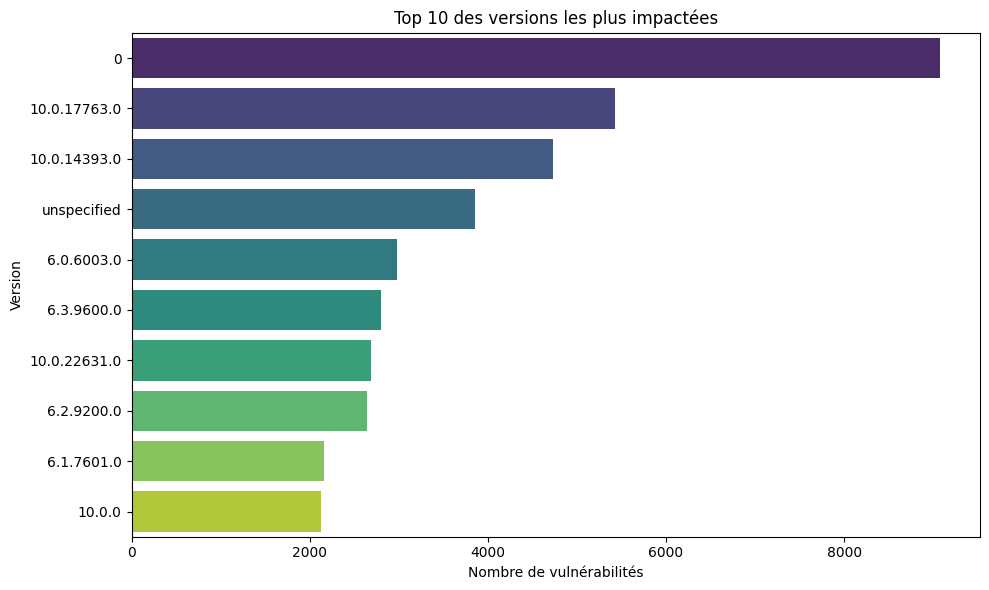

In [157]:
plt.figure(figsize=(10, 6))
sns.barplot(y=version_counts.index, x=version_counts.values, palette="viridis")

plt.title("Top 10 des versions les plus impactées")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Version")
plt.tight_layout()
plt.show()

## 17. Evolution temporelle des vulnérabilités par type de bulletin (Avis/Alertes)

In [158]:
df['Type'] = df['Type'].str.strip() 
df = df[df['Type'].isin(['Avis', 'Alerte'])]

In [159]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Mois'] = df['Date'].dt.to_period('M').astype(str)

Groupe par mois et par type (avis/alerte)

In [160]:
df_evol = df.groupby(['Mois', 'Type']).size().reset_index(name='Nombre')

Tri par mois chronologique

In [161]:
df_evol['Mois'] = pd.to_datetime(df_evol['Mois'])
df_evol = df_evol.sort_values('Mois')

Plot

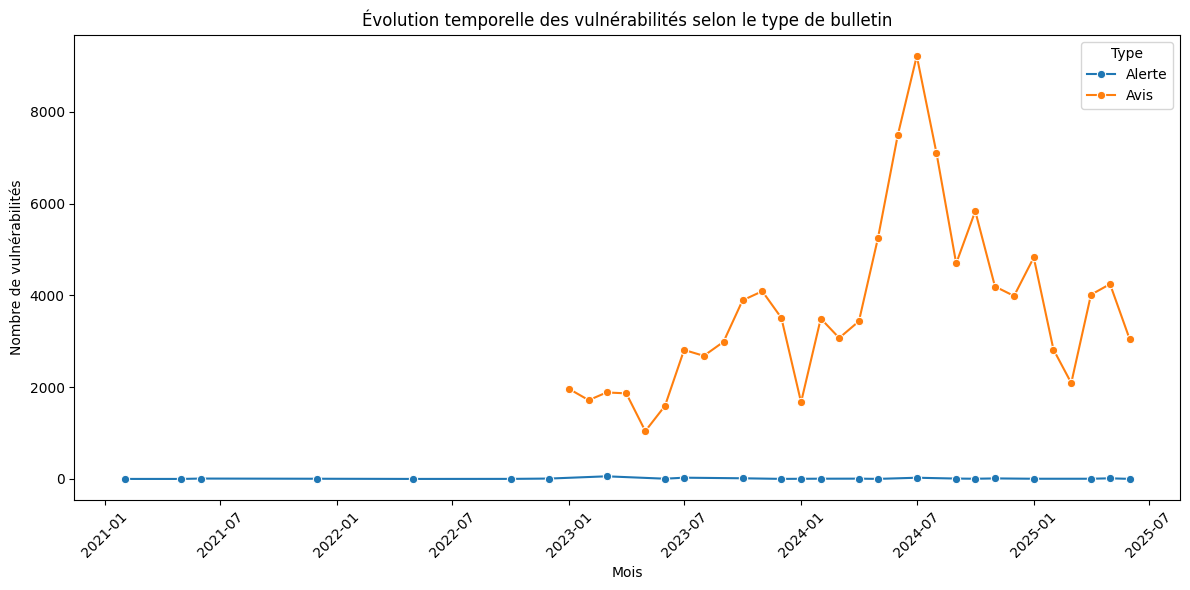

In [162]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_evol, x='Mois', y='Nombre', hue='Type', marker='o')
plt.title("Évolution temporelle des vulnérabilités selon le type de bulletin")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 18. Vulnerabilités par editeur et type (alerte/avis)

Grouper par editeur et type

In [163]:
df_bar = df.groupby(['Éditeur', 'Type']).size().unstack(fill_value=0)

Garder les 15 éditeurs les plus fréquents

In [164]:
df_bar = df_bar.sort_values(df_bar.columns.tolist(), ascending=False).head(15)

Plot

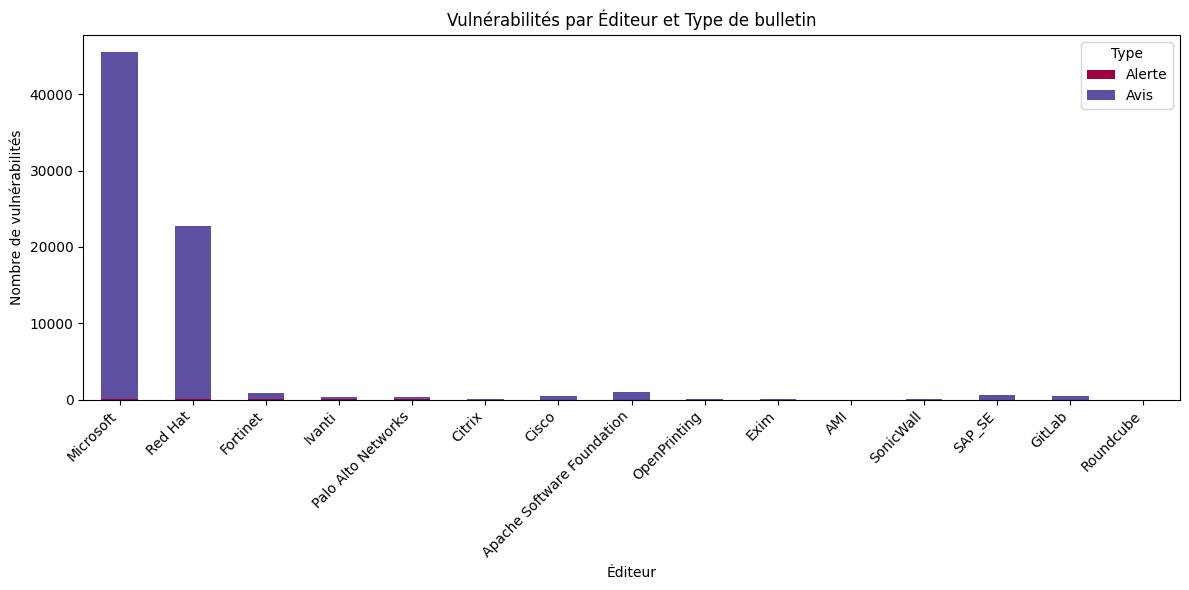

In [165]:

df_bar.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Spectral')
plt.title("Vulnérabilités par Éditeur et Type de bulletin")
plt.xlabel("Éditeur")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 19. Boxplot - Gravité (CVSS) par type de bulletin

Plot

C:\Users\eva2p\AppData\Local\Temp\ipykernel_15128\3635914293.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Type", y="CVSS", palette="Set1")


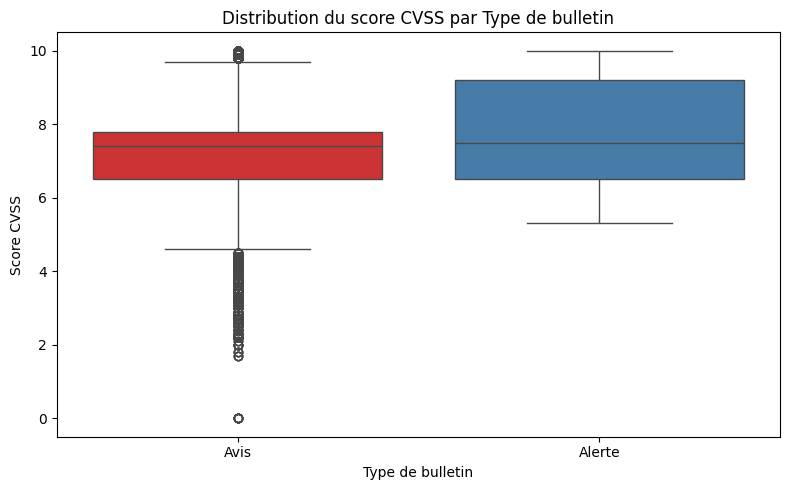

In [166]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Type", y="CVSS", palette="Set1")
plt.title("Distribution du score CVSS par Type de bulletin")
plt.xlabel("Type de bulletin")
plt.ylabel("Score CVSS")
plt.tight_layout()
plt.show()

## 20. Heatmap : nombre de vulnerabilités

Garder les 15 editeurs les plus fréquents

In [167]:
top_editeurs = df['Éditeur'].value_counts().head(15).index
df_top = df[df['Éditeur'].isin(top_editeurs)]

Heatmap

In [168]:
heat_data = df_top.groupby(['Éditeur', 'Base Severity']).size().unstack(fill_value=0)
severity_order = ['Critique', 'Élevée', 'Moyenne', 'Faible', 'Non spécifié']
heat_data = heat_data[[s for s in severity_order if s in heat_data.columns]]

Plot

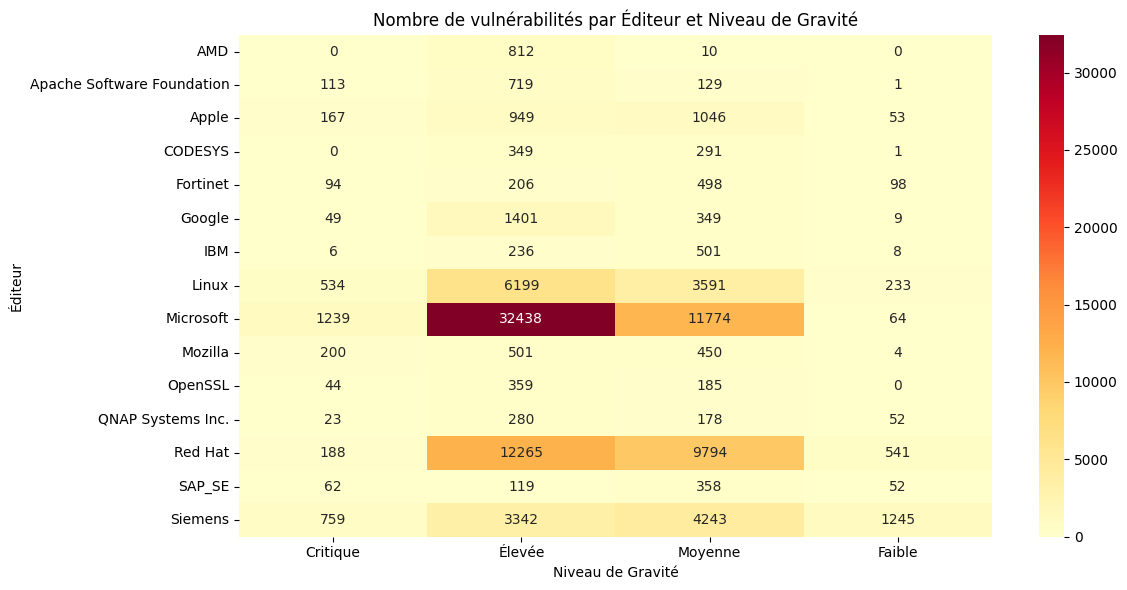

In [169]:
plt.figure(figsize=(12, 6))
sns.heatmap(heat_data, annot=True, fmt='d', cmap='YlOrRd')
plt.title("Nombre de vulnérabilités par Éditeur et Niveau de Gravité")
plt.xlabel("Niveau de Gravité")
plt.ylabel("Éditeur")
plt.tight_layout()
plt.show()

## 21. Boxplot : Longueur de la description selon l'éditeur

In [170]:
top_editeurs = df["Éditeur"].value_counts().head(20).index
df_top_editeurs = df[df["Éditeur"].isin(top_editeurs)]

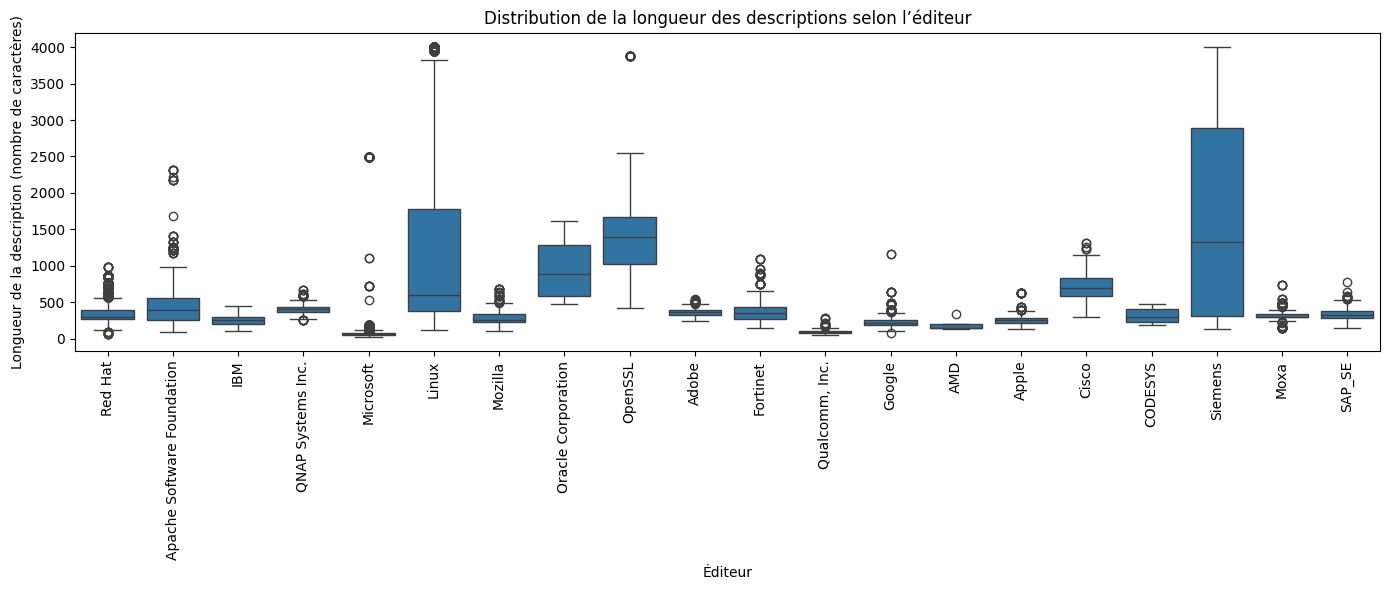

In [171]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_top_editeurs, x="Éditeur", y="Longueur description")
plt.xticks(rotation=90)
plt.title("Distribution de la longueur des descriptions selon l’éditeur")
plt.xlabel("Éditeur")
plt.ylabel("Longueur de la description (nombre de caractères)")
plt.tight_layout()
plt.show()


## 22. Boxplot : Remote exploitable vs score EPSS

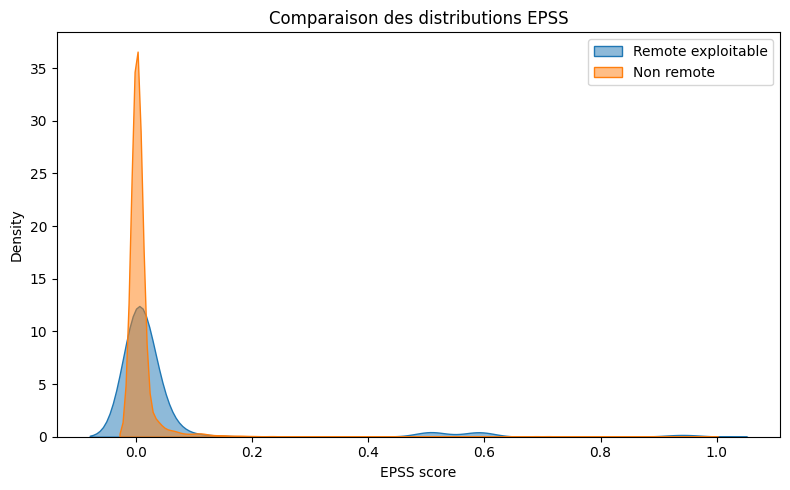

In [172]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df[df["Remote exploitable"] == True]["EPSS"], label="Remote exploitable", fill=True, alpha=0.5)
sns.kdeplot(df[df["Remote exploitable"] == False]["EPSS"], label="Non remote", fill=True, alpha=0.5)
plt.title("Comparaison des distributions EPSS")
plt.xlabel("EPSS score")
plt.legend()
plt.tight_layout()
plt.show()

## 23. Remote exploitable vs score CVSS

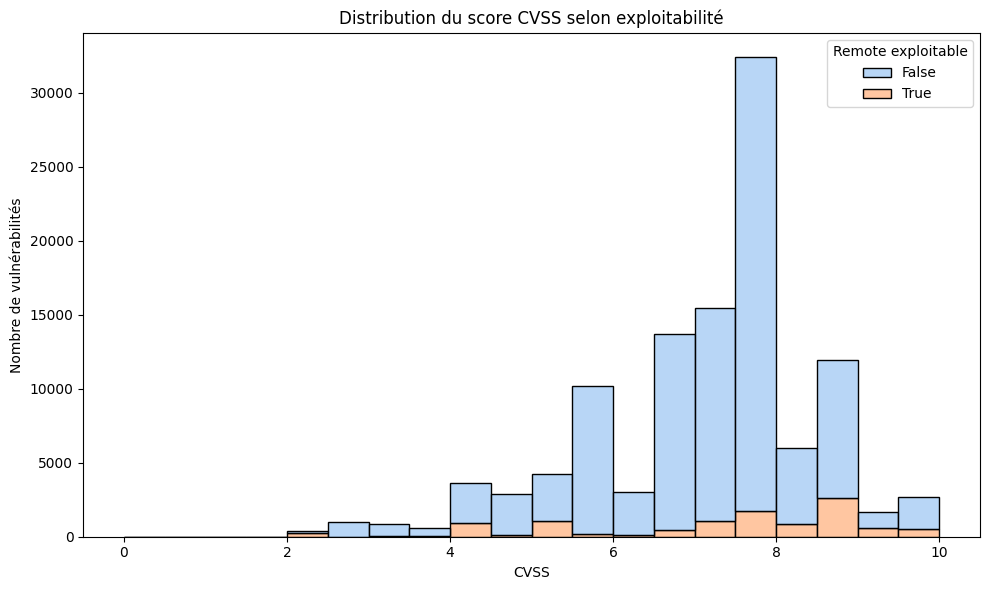

In [173]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="CVSS", hue="Remote exploitable", multiple="stack", bins=20, palette="pastel")
plt.title("Distribution du score CVSS selon exploitabilité")
plt.xlabel("CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.tight_layout()
plt.show()


## 24. 3 CWE les plus fréquents pour chaque éditeur

In [174]:
top_editors = df["Éditeur"].value_counts().head(6).index
df_filtered = df[df["Éditeur"].isin(top_editors)]

Obtenir les 3 CWE les plus fréquents pour chaque éditeur

In [175]:
top_cwes_per_editor = (
    df_filtered.groupby(["Éditeur", "CWE"])
    .size()
    .reset_index(name="count")
    .sort_values(["Éditeur", "count"], ascending=[True, False])
    .groupby("Éditeur")
    .head(3)
)

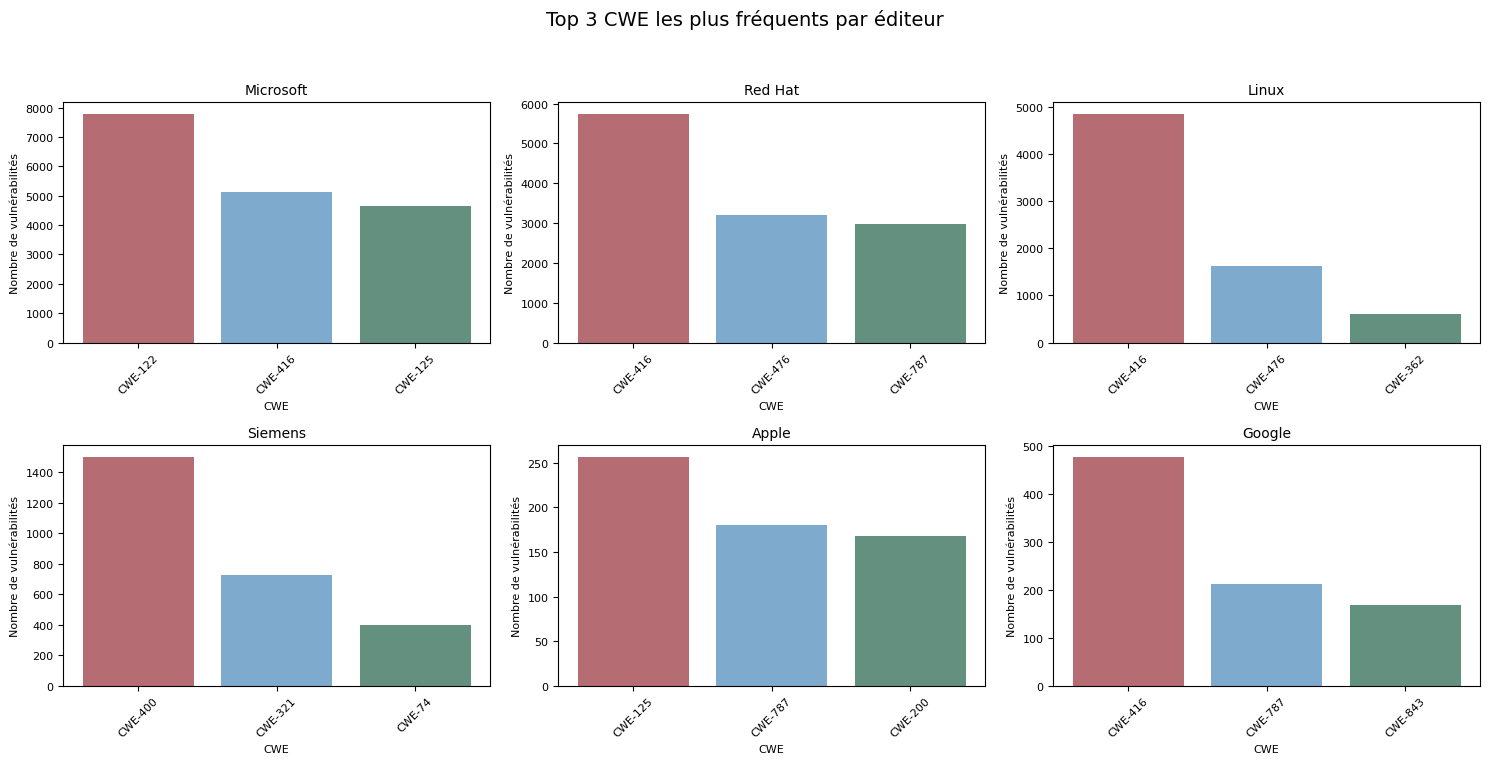

In [176]:
n_editors = len(top_editors)
n_cols = 3
n_rows = (n_editors + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
axes = axes.flatten()

colors = ["#B56C73", "#7DAACD", "#649080"]  # Couleurs pastel

for i, editor in enumerate(top_editors):
    ax = axes[i]
    data = top_cwes_per_editor[top_cwes_per_editor["Éditeur"] == editor]
    ax.bar(data["CWE"], data["count"], color=colors[:len(data)])
    ax.set_title(editor, fontsize=10)
    ax.set_xlabel("CWE", fontsize=8)
    ax.set_ylabel("Nombre de vulnérabilités", fontsize=8)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Supprimer les axes vides si le nombre d’éditeurs < n_rows * n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Top 3 CWE les plus fréquents par éditeur", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Modèles supervisés**

## Random Forest pour prédire Base Severity

Labellisation

In [177]:
features = ['Type', 'CWE', 'EPSS', 'Remote exploitable', 'Longueur description']
target = 'Base Severity'

le_type = LabelEncoder()
le_cwe = LabelEncoder()
le_target = LabelEncoder()

df_IA['Type'] = le_type.fit_transform(df_IA['Type'])
df_IA['CWE'] = le_cwe.fit_transform(df_IA['CWE'])
df_IA[target] = le_target.fit_transform(df_IA[target])

In [178]:
X = df_IA[features]
y = df_IA[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modèle Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Évaluation

In [179]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy : 0.9648520959345189
Classification report:
              precision    recall  f1-score   support

    Critique       0.96      0.87      0.91      1322
      Faible       0.98      0.86      0.91       801
     Moyenne       0.95      0.96      0.96     11323
      Élevée       0.97      0.98      0.97     19785

    accuracy                           0.96     33231
   macro avg       0.97      0.92      0.94     33231
weighted avg       0.96      0.96      0.96     33231

Confusion matrix:
[[ 1152     1    43   126]
 [    3   688    69    41]
 [   13     7 10880   423]
 [   29     7   406 19343]]


Visualisation

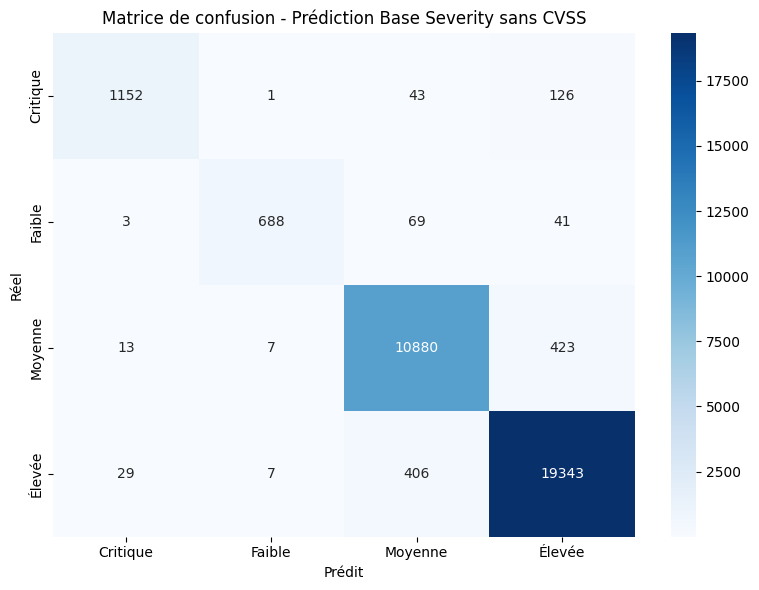

In [180]:
cm = confusion_matrix(y_test, y_pred)
labels = le_target.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion - Prédiction Base Severity sans CVSS')
plt.tight_layout()
plt.show()

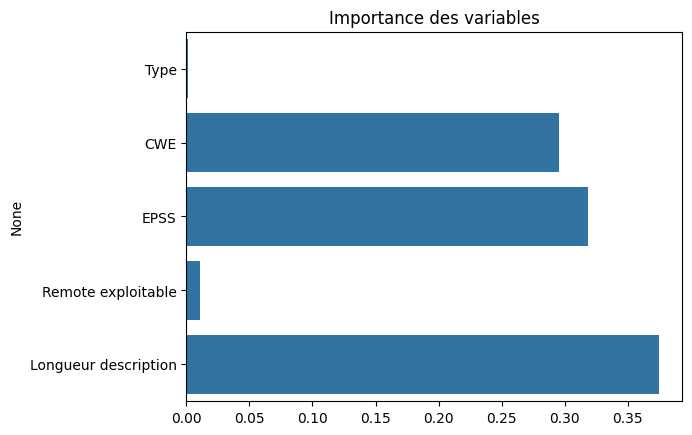

In [181]:
importances = model.feature_importances_
sns.barplot(x=importances, y=X.columns)
plt.title("Importance des variables")
plt.show()

Cross Validation

In [182]:
model_cv = RandomForestClassifier(random_state=42)

scores_acc = cross_val_score(model_cv, X, y, cv=5, scoring='accuracy')
print("Accuracy :", scores_acc.mean())

Accuracy : 0.8170443260810689


## Random Forest pour prédire EPSS

Data preparing

In [183]:
df_reg = df_IA.copy()
df_reg = df_reg[df_reg['EPSS'].notna()]
df_reg = df_reg[df_reg['EPSS'] != '']
df_reg['EPSS'] = df_reg['EPSS'].astype(float)

features = ['CWE','Type','Éditeur','Produit','Remote exploitable','Longueur description']

Labellisation

In [184]:
df_encoded = df_reg[features].copy()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

Modèle Random Forest

In [185]:
X = df_encoded
y = df_reg['EPSS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [186]:
print("MAE :", mean_absolute_error(y_test, y_pred))
print("MSE :", mean_squared_error(y_test, y_pred))
#print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

print("R²  :", r2_score(y_test, y_pred))

MAE : 0.017499425805469596
MSE : 0.0054251691460842095
RMSE: 0.0736557475427696
R²  : 0.4428524093068221


Cross Validation

In [187]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores_mae = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
scores_rmse = (-cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error'))
scores_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')

print("MAE  : ", scores_mae.mean())
print("RMSE : ", scores_rmse.mean())
print("R²   : ", scores_r2.mean())

MAE  :  0.017421834985697774
RMSE :  0.07400998006061796
R²   :  0.48131027797977166


Visualisation

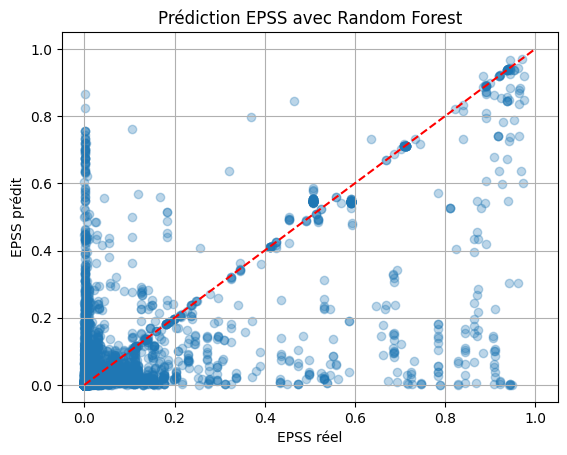

In [188]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("EPSS réel")
plt.ylabel("EPSS prédit")
plt.title("Prédiction EPSS avec Random Forest")
plt.plot([0, 1], [0, 1], 'r--')
plt.grid()
plt.show()

## XGBoost Regressor pour prédire EPSS

In [190]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MAE :", mean_absolute_error(y_test, y_pred))
#print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("R²  :", r2_score(y_test, y_pred))

MAE : 0.022668994776665383
RMSE: 0.07125113855565249
R²  : 0.4786365393609193


Cross Validation

In [191]:
scores_mae = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
scores_rmse = -cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
scores_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')


print("MAE  : ", scores_mae.mean())
print("RMSE : ", scores_rmse.mean())
print("R²   : ", scores_r2.mean())

MAE  :  0.02330083302813823
RMSE :  0.07485867174848032
R²   :  0.47024970919065934


## Random Forest pour prédire l'éditeur

Random Forest sans SMOTE (échantillonage)

In [192]:
df_clf = df_IA.dropna(subset=["CVSS", "EPSS", "CWE", "Remote exploitable", "Longueur description"])
df_clf = df_clf[df_clf["Éditeur"].map(df_clf["Éditeur"].value_counts()) > 50]  # éditeurs fréquents

le_editeur = LabelEncoder()
df_clf["Éditeur_encoded"] = le_editeur.fit_transform(df_clf["Éditeur"])

le_cwe = LabelEncoder()
df_clf["CWE_encoded"] = le_cwe.fit_transform(df_clf["CWE"].astype(str))

df_clf["Remote Exploitable"] = df_clf["Remote exploitable"].map({"True": 1, "False": 0})
df_clf["Remote Exploitable"].fillna(0, inplace=True)


features = [
    "CVSS",
    "EPSS",
    "CWE_encoded",
    "Remote Exploitable",
    "Longueur description"
]

X = df_clf[features]
y = df_clf["Éditeur_encoded"]


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le_editeur.classes_))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))


C:\Users\eva2p\AppData\Local\Temp\ipykernel_15128\1980252062.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clf["Remote Exploitable"].fillna(0, inplace=True)


Accuracy : 0.9697054047784737
                                  precision    recall  f1-score   support

                             AMD       1.00      0.99      1.00       158
                           Adobe       0.86      0.75      0.80        79
      Apache Software Foundation       0.91      0.92      0.91       187
                           Apple       0.87      0.98      0.92       430
                         Arm Ltd       0.95      0.95      0.95        21
          Axis Communications AB       1.00      0.67      0.80         9
                         CODESYS       0.99      0.99      0.99       130
                           Cisco       0.88      0.82      0.85        96
              ESET, spol. s r.o.       0.90      1.00      0.95        19
              Eclipse Foundation       1.00      1.00      1.00        18
                         Elastic       0.75      0.29      0.41        21
                              F5       0.84      0.66      0.74        58
       

Cross Validation

In [193]:
scores_acc = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Accuracy :", scores_acc.mean())

c:\Users\eva2p\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\eva2p\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\eva2p\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\eva2p\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\eva2p\AppData\Local\Programs\Python\Python312\Lib\site-pack

Accuracy : 0.8987326214510413


Visualisation

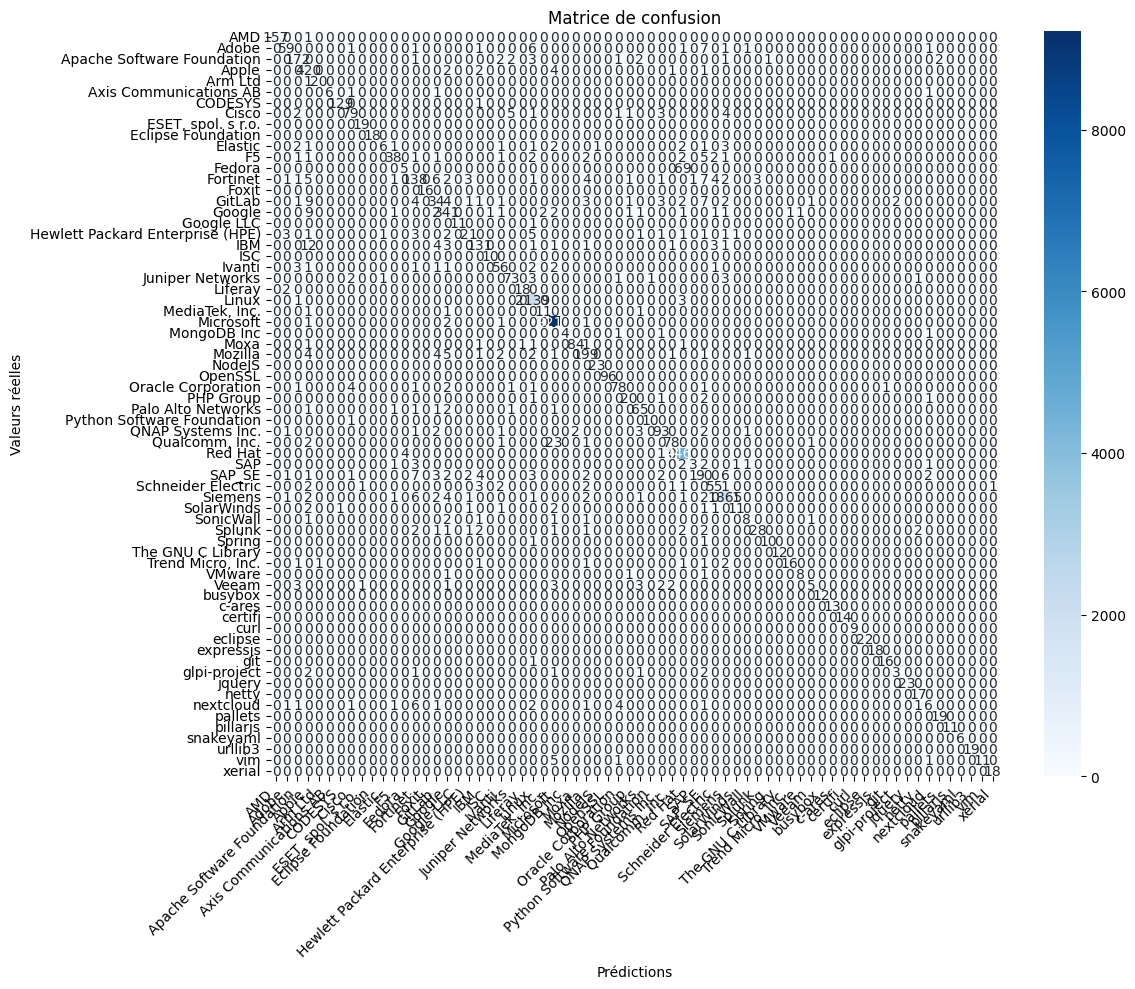

In [194]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_editeur.classes_,
            yticklabels=le_editeur.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Random Forest avec SMOTE

In [195]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)


y_pred = model.predict(X_test)


print("Accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le_editeur.classes_))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

ModuleNotFoundError: No module named 'imblearn.utils._tags'

Cross Validation

In [ ]:
scores_acc = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Accuracy :", scores_acc.mean())

Accuracy : 0.8987326214510413


Visualisation

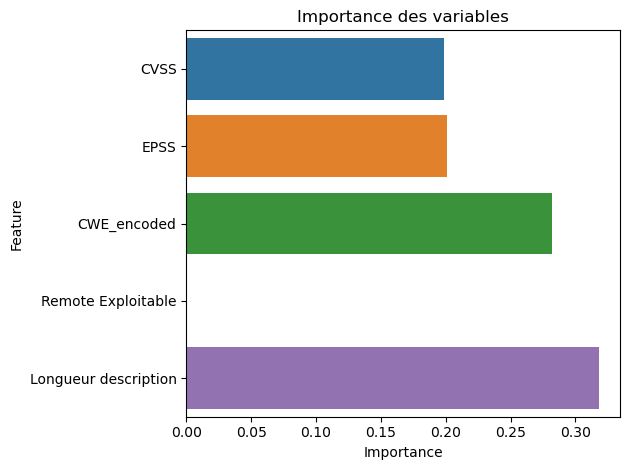

In [ ]:
importances = model.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Importance des variables")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

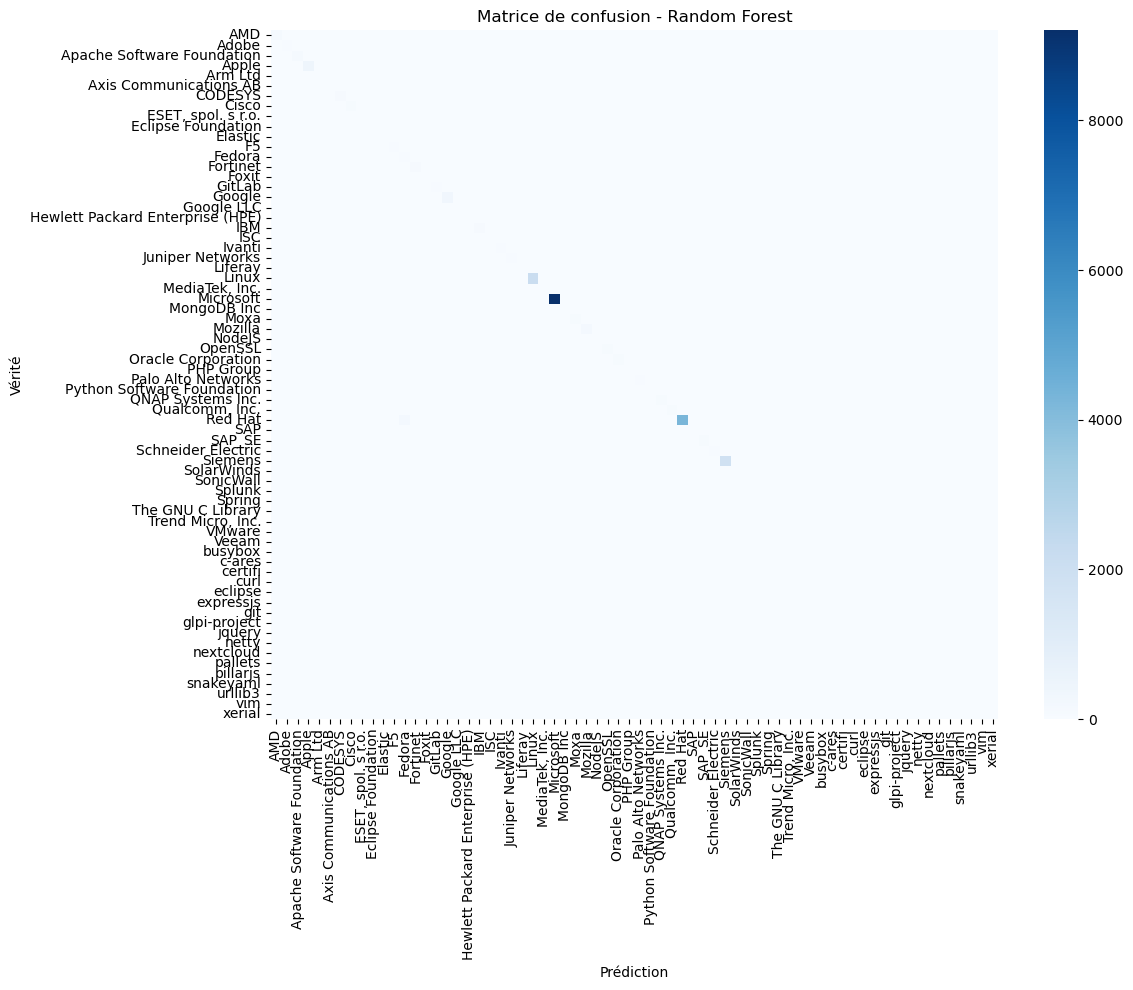

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=le_editeur.classes_,
            yticklabels=le_editeur.classes_, 
            annot=False, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - Random Forest")
plt.xlabel("Prédiction")
plt.ylabel("Vérité")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


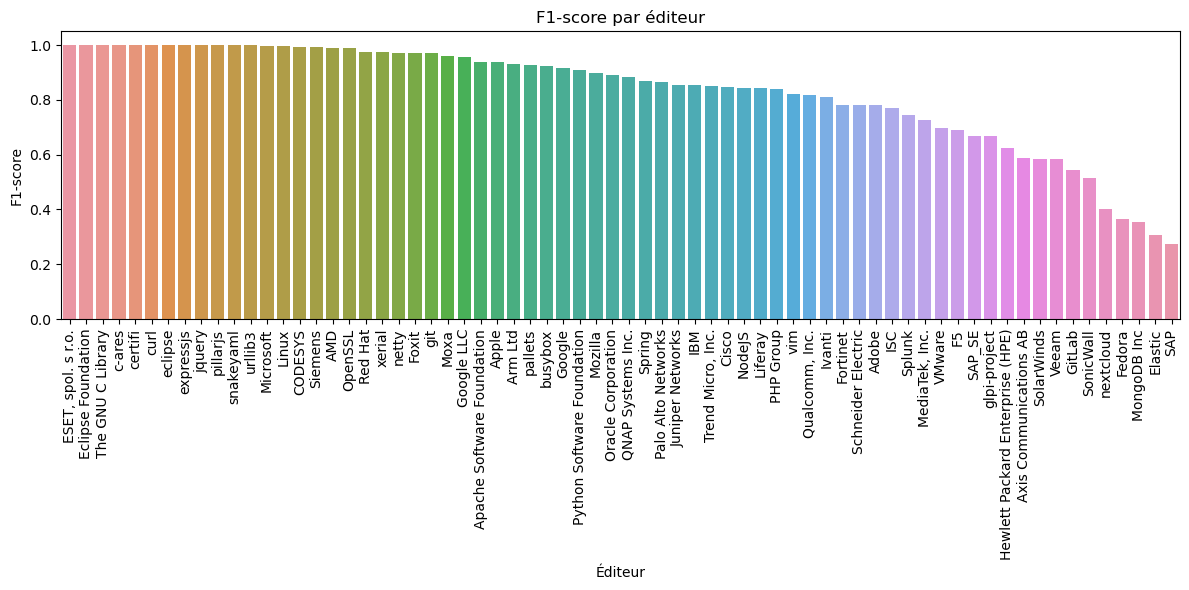

In [ ]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
f1_scores = {}
for i, label in enumerate(le_editeur.classes_):
    try:
        f1_scores[label] = report_dict[str(i)]["f1-score"]
    except KeyError:
        f1_scores[label] = 0


f1_scores_sorted = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 6))
sns.barplot(x=list(f1_scores_sorted.keys()), y=list(f1_scores_sorted.values()))
plt.xticks(rotation=90)
plt.title("F1-score par éditeur")
plt.ylabel("F1-score")
plt.xlabel("Éditeur")
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


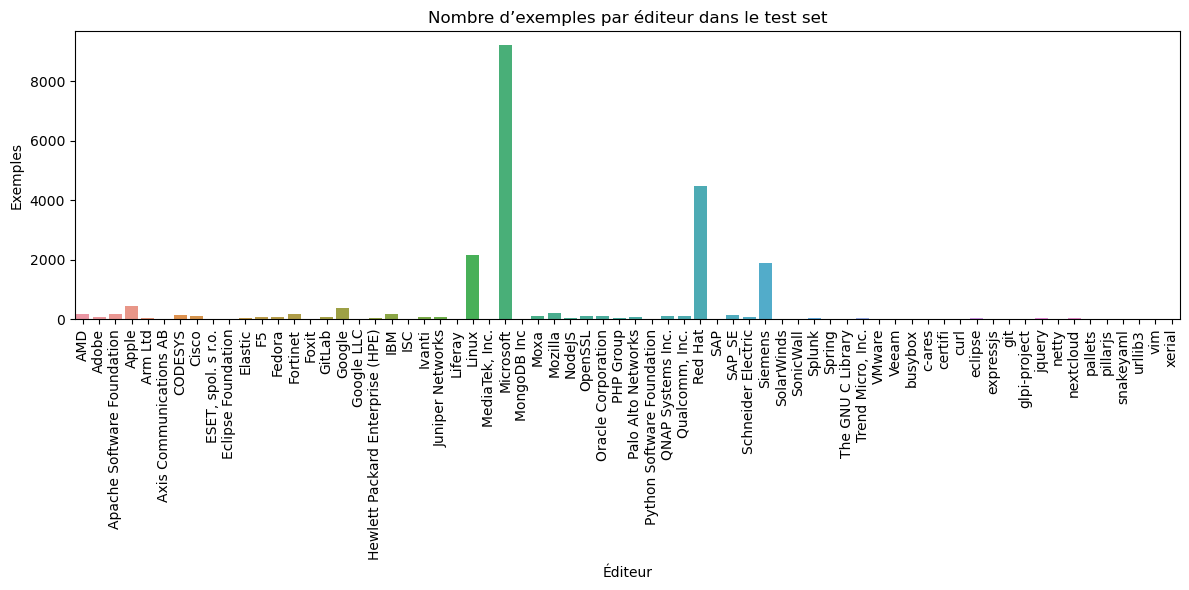

In [ ]:
support = {}
for i, label in enumerate(le_editeur.classes_):
    try:
        support[label] = report_dict[str(i)]["support"]
    except KeyError:
        support[label] = 0  


plt.figure(figsize=(12, 6))
sns.barplot(x=list(support.keys()), y=list(support.values()))
plt.xticks(rotation=90)
plt.title("Nombre d’exemples par éditeur dans le test set")
plt.ylabel("Exemples")
plt.xlabel("Éditeur")
plt.tight_layout()
plt.show()